In [7]:
import torchvision
import torch
import numpy as np
from collections import defaultdict
import torch.nn as nn
from ast import Continue

import pandas as pd
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cpu


In [8]:
#mnist = torchvision.datasets.MNIST(root = './data/',download=True)

In [9]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/11-785 Project/MNIST_CSV.zip' MNIST_CSV.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!unzip MNIST_CSV.zip

Archive:  MNIST_CSV.zip
  inflating: generate_mnist_csv.py   
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         
  inflating: readme.md               


In [11]:
n_epochs = 3
batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
HYPER_GRAYSCALE = True

In [12]:
train_set = pd.read_csv("mnist_train.csv")
test_images = pd.read_csv("mnist_test.csv")

train_images, val_images, train_labels, val_labels = train_test_split(train_set.iloc[:, 1:],
                                                                     train_set.iloc[:, 0],
                                                                     test_size=0.3)

train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

train_images = train_images.to_numpy(dtype='float32')
train_labels = train_labels.to_numpy(dtype='float32')

val_images = val_images.to_numpy(dtype='float32')
val_labels = val_labels.to_numpy(dtype='float32')

test_images = test_images.to_numpy(dtype='float32')

## Jigsaw Datasets

In [13]:
class JigsawDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, permutations=10, img_transformer=None):
        self.images = images
        self.labels = labels
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_tiles(self, index):
        img = self.__get_image(index).reshape(28, 28)
        tiles = np.zeros((9, 9, 9), dtype='float32')

        for i in range(3):
            for j in range(3):
                tiles[i * 3 + j] = img[i*9:i*9+9, j*9:j*9+9]

        return tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        tiles = self.__get_tiles(index)

        order = self.__retrieve_permutations()

        data_index = torch.from_numpy(np.array(order))

        data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]

        item = torch.stack(data, 0)
        return item, order, int(self.labels[index])

    def __len__(self):
        return self.N

In [14]:
class JigsawDataset_State(torch.utils.data.Dataset):
    def __init__(self, images, labels, permutations=10, img_transformer=None, img_grayscale = HYPER_GRAYSCALE):
        self.images = images
        self.labels = labels
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3
        self.GRAYSCALE = HYPER_GRAYSCALE

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        img = self.images[index].reshape(28, 28)
        if self.GRAYSCALE:
          img = np.repeat(img[ np.newaxis, :, :], 3, axis=0)
        return img

    def __get_state(self, index, current_pieces, piece_list, order, tile_list):
        img = self.__get_image(index)
        tiles = np.zeros((9, 3, 9, 9), dtype='float32')

        for i in range(3):
          for j in range(3):

            a = i * 3 + j
            tiles[a] = img[:,i*9:i*9+9, j*9:j*9+9]
            if a not in piece_list:
              img[:,i*9:i*9+9, j*9:j*9+9] = 0

        return img, tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2

        current_pieces = np.random.randint(0,9)
        current_pieces = 8
        order = self.__retrieve_permutations()

        piece_list = np.random.choice(9, current_pieces, replace=False)
        # piece_list = [piece_list_unshuffled[x] for x in order]
        tile_list = [i for i in order if i not in piece_list]


        img, tiles = self.__get_state(index, current_pieces, piece_list, order, tile_list)

        data_index = torch.from_numpy(np.array(order))

        tiles_shuffl = [torch.from_numpy(tiles[x]) for x in tile_list]


        return img, current_pieces, tiles, tiles_shuffl[0], tile_list[0], order, int(self.labels[index])

    def __len__(self):
        return self.N

### Test Datasets

In [15]:
class JigsawDatasetTest(torch.utils.data.Dataset):
    def __init__(self, images, permutations=10, img_transformer=None):
        self.images = images
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_tiles(self, index):
        img = self.__get_image(index).reshape(28, 28)
        tiles = np.zeros((9, 9, 9), dtype='float32')

        for i in range(3):
            for j in range(3):
                tiles[i * 3 + j] = img[i*9:i*9+9, j*9:j*9+9]

        return tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        tiles = self.__get_tiles(index)

        order = self.__retrieve_permutations()

        data_index = torch.from_numpy(np.array(order))

        data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]

        item = torch.stack(data, 0)
        return item, order

    def __len__(self):
        return self.N

In [16]:
class JigsawDatasetTest_State(torch.utils.data.Dataset):
    def __init__(self, images, permutations=10, img_transformer=None):
        self.images = images
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        """
        permutations = []
        for i in range(self.permutations):
            permutations.append(np.random.permutation(nums))
        """

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_tiles(self, index):
        img = self.__get_image(index).reshape(28, 28)
        tiles = np.zeros((9, 9, 9), dtype='float32')

        for i in range(3):
            for j in range(3):
                tiles[i * 3 + j] = img[i*9:i*9+9, j*9:j*9+9]

        return tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        tiles = self.__get_tiles(index)

        order = self.__retrieve_permutations()

        data_index = torch.from_numpy(np.array(order))

        data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]

        item = torch.stack(data, 0)
        return item, order

    def __len__(self):
        return self.N

# Initialize the Datasets

In [17]:
train_data = JigsawDataset(train_images, train_labels)
val_data = JigsawDataset(val_images, val_labels)
test_data = JigsawDatasetTest(test_images)

train_loader = torch.utils.data.DataLoader(
        dataset     = train_data,
        num_workers = 2,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = True,
)

val_loader = torch.utils.data.DataLoader(
        dataset     = val_data,
        num_workers = 1,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = False,
    )

test_loader = torch.utils.data.DataLoader(
        dataset     = test_data,
        num_workers = 1,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = False,
    )

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))


Train dataset samples = 41999, batches = 41999
Val dataset samples = 18000, batches = 18000
Test dataset samples = 9999, batches = 9999


In [18]:
train_data_state = JigsawDataset_State(train_images, train_labels)
val_data_state = JigsawDataset_State(val_images, val_labels)
test_data_state = JigsawDatasetTest_State(test_images)

train_loader_state = torch.utils.data.DataLoader(
        dataset     = train_data_state,
        num_workers = 2,
        batch_size  = batch_size_train,
        pin_memory  = True,
        shuffle     = True,
)

val_loader_state = torch.utils.data.DataLoader(
        dataset     = val_data_state,
        num_workers = 1,
        batch_size  = batch_size_train,
        pin_memory  = True,
        shuffle     = False,
    )

test_loader_state = torch.utils.data.DataLoader(
        dataset     = test_data_state,
        num_workers = 1,
        batch_size  = batch_size_test,
        pin_memory  = True,
        shuffle     = False,
    )

### Test the Datasets and Plot some inputs

tensor([[4, 7, 3, 2, 6, 0, 5, 8, 1]])
tensor([0])
tensor([5])
tensor([8])
tensor([3])
tensor([2])
tensor([0])
tensor([6])
tensor([4])
tensor([1])
tensor([7])


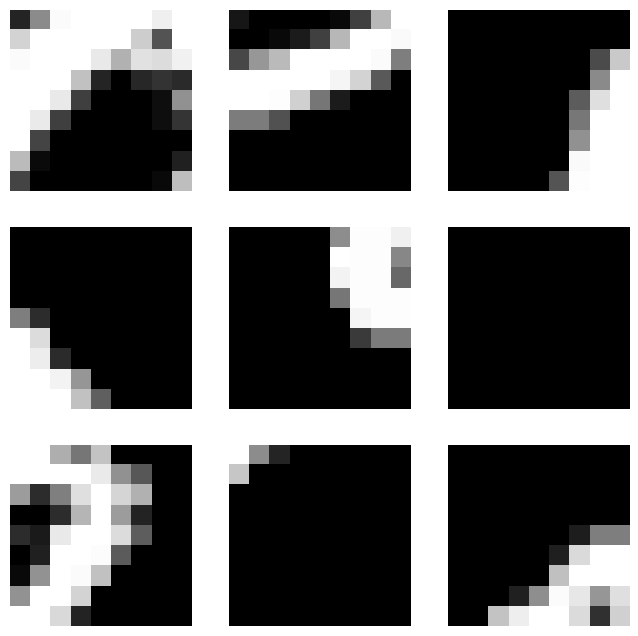

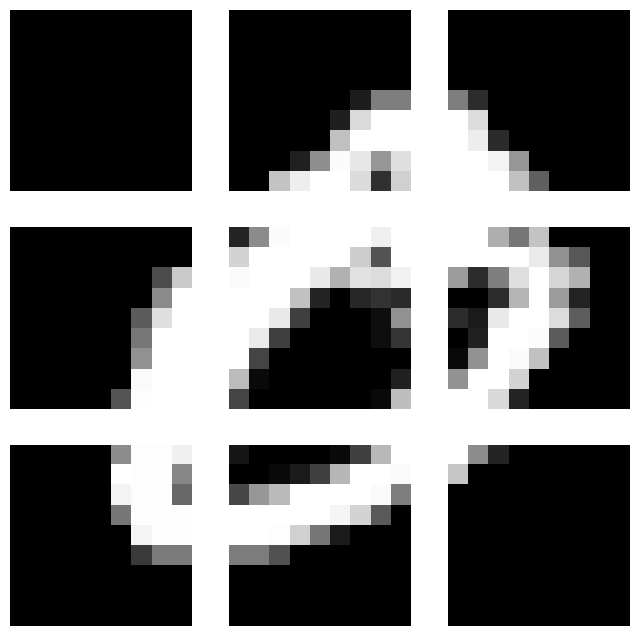

In [19]:
import matplotlib.pyplot as plt

for tiles, order, label in train_loader:
  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
  fig.subplots_adjust(hspace=.2)

  for i in range(3):
      for j in range(3):
          ax[i][j].axis('off')
          ax[i][j].imshow(tiles[0][i * 3 + j], cmap='gray')
  print(order)
  print(label)

  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
  fig.subplots_adjust(hspace=.2)

  for i in range(3):
      for j in range(3):
          ax[i][j].axis('off')
          print((order[0]==i * 3 + j).nonzero(as_tuple=True)[0])
          ax[i][j].imshow(tiles[0][(order[0]==i * 3 + j).nonzero(as_tuple=True)[0].item()], cmap='gray')

  break

torch.Size([32, 3, 28, 28])
torch.Size([32, 3, 9, 9])
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8])
tensor([3, 0, 7, 2, 4, 8, 7, 5, 3, 3, 6, 6, 0, 6, 2, 1, 1, 1, 7, 0, 2, 6, 5, 5,
        4, 6, 7, 3, 8, 6, 2, 8])
tensor([6, 0, 1, 2, 3, 4, 8, 7, 5])


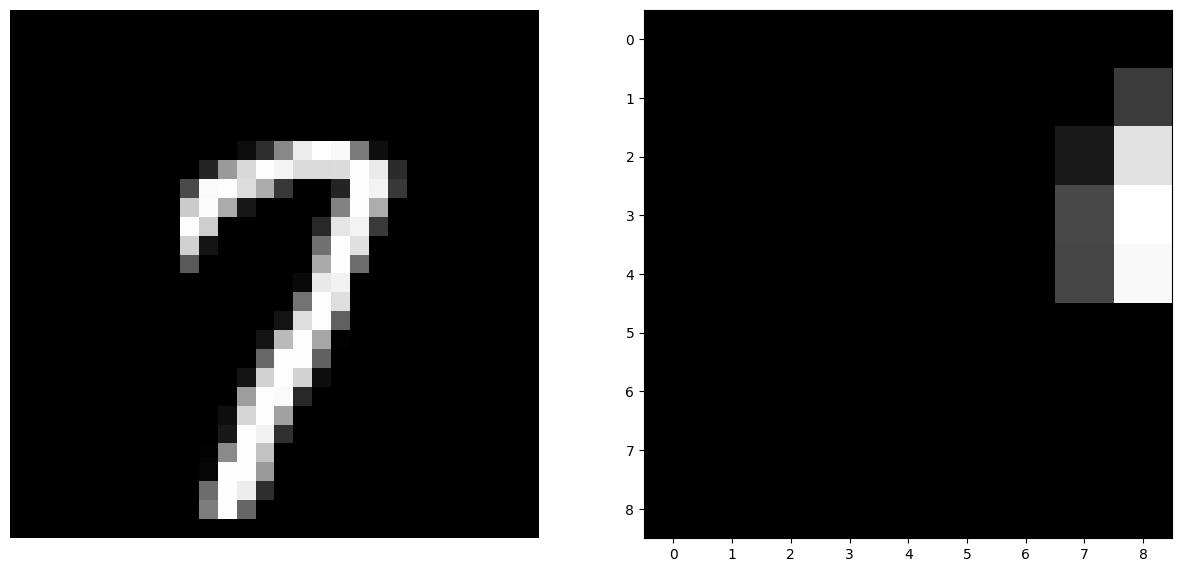

In [20]:
for img, cur_pieces, tiles, tiles_shuffl, tile_list, order, label in train_loader_state:
  fig, ax = plt.subplots( ncols=2, figsize=(15,15))
  fig.subplots_adjust(hspace=.2)

  print(img.shape)
  print(tiles_shuffl.shape)
  # print(cur_pieces[0])
  ax[0].axis('off')
  ax[0].imshow(img[0,0,:,:], cmap='gray')
  print(cur_pieces)
  print(tile_list)
  print(order[0])
  ax[1].imshow(tiles_shuffl[0,0,:,:], cmap='gray')

  break

## Monte Carlo Model

In [21]:
class MonteCarloTreeSearchNode():
    def __init__(self, state, parent=None, parent_action=None):
        self.state = state
        self.parent = parent
        self.parent_action = parent_action
        self.children = []
        self._number_of_visits = 0
        self._results =  []
        # self._results[1] = 0
        # self._results[-1] = 0
        self._untried_actions = None
        self._untried_actions = self.untried_actions()
        return

    def untried_actions(self):

        self._untried_actions = self.state.get_legal_actions()
        return self._untried_actions
    # Returns the list of untried actions from a given state. For the first turn of our game there are 81 possible actions. For the second turn it is 8 or 9. This varies in our game.

    def q(self):
        score = np.sum(self._results)
        return score
    # Returns the difference of wins - losses

    def n(self):
        return self._number_of_visits
    # Returns the number of times each node is visited.

    def expand(self):

        action = self._untried_actions.pop() #Maybe add ran
        next_state = self.state.move(action)
        child_node = MonteCarloTreeSearchNode(
        next_state, parent=self, parent_action=action)

        self.children.append(child_node)
        return child_node
    # From the present state, next state is generated depending on the action which is carried out. In this step all the possible child nodes corresponding to generated states are appended to the children array and the child_node is returned. The states which are possible from the present state are all generated and the child_node corresponding to this generated state is returned.

    def is_terminal_node(self):
        return self.state.is_game_over()
    # This is used to check if the current node is terminal or not. Terminal node is reached when the game is over.

    def rollout(self):
        current_rollout_state = self.state

        while not current_rollout_state.is_game_over():

            possible_moves = current_rollout_state.get_legal_actions()

            action = self.rollout_policy(possible_moves)
            current_rollout_state = current_rollout_state.move(action)
        # print('in rollout', current_rollout_state.tiles_selected)
        return current_rollout_state.game_result()
    # From the current state, entire game is simulated till there is an outcome for the game. This outcome of the game is returned. For example if it results in a win, the outcome is 1. Otherwise it is -1 if it results in a loss. And it is 0 if it is a tie. If the entire game is randomly simulated, that is at each turn the move is randomly selected out of set of possible moves, it is called light playout.

    def backpropagate(self, result):
        self._number_of_visits += 1.
        self._results += [result]
        # print('Backpropagate', self.state.tiles_selected, self._results)
        if self.parent:
            self.parent.backpropagate(result)
    # In this step all the statistics for the nodes are updated. Untill the parent node is reached, the number of visits for each node is incremented by 1. If the result is 1, that is it resulted in a win, then the win is incremented by 1. Otherwise if result is a loss, then loss is incremented by 1.

    def is_fully_expanded(self):
        return len(self._untried_actions) == 0

    # All the actions are poped out of _untried_actions one by one. When it becomes empty, that is when the size is zero, it is fully expanded.

    def best_child(self, c_param=0.1):

        # print('best_child',[x.state.tiles_selected for x in self.children])
        choices_weights = [(c.q() / c.n()) + c_param * np.sqrt((2 * np.log(self.n()) / c.n())) for c in self.children]
        # print('choices_weights', choices_weights)
        return self.children[np.argmax(choices_weights)]

    # Once fully expanded, this function selects the best child out of the children array. The first term in the formula corresponds to exploitation and the second term corresponds to exploration.

    def rollout_policy(self, possible_moves):

        return possible_moves[np.random.randint(len(possible_moves))]

    # Randomly selects a move out of possible moves. This is an example of random playout.

    def _tree_policy(self):

        current_node = self
        while not current_node.is_terminal_node():

            if not current_node.is_fully_expanded():
                return current_node.expand()
            else:
                # print('going into best child')
                # print('current_node', current_node.state.tiles_selected)
                current_node = current_node.best_child()
                # print('best_child', current_node.state.tiles_selected)
                # print('is_terminal', current_node.is_terminal_node())
        return current_node
    # Selects node to run rollout.

    def best_action(self):
        simulation_no = 100


        for i in range(simulation_no):
            # print('sim',i)
            v = self._tree_policy()
            # print('Tree policy',v.state.tiles_selected)
            reward = v.rollout()
            v.backpropagate(reward)
            # print('reward',v.state.tiles_selected, reward)

        return self.best_child(c_param=0.)
    # This is the best action function which returns the node corresponding to best possible move. The step of expansion, simulation and backpropagation are carried out by the code above.

class State:
    def __init__(self, tiles_selected=[], final_shuffle_list=None):
        self.tiles_selected = tiles_selected
        self.final_shuffle_list = final_shuffle_list

    def get_legal_actions(self):
        '''
        Modify according to your game or
        needs. Constructs a list of all
        possible actions from current state.
        Returns a list.
        '''
        total_tiles = list(range(0,9))
        legal_actions = [i for i in total_tiles if i not in self.tiles_selected]
        return legal_actions

    def is_game_over(self):
        '''
        Modify according to your game or
        needs. It is the game over condition
        and depends on your game. Returns
        true or false
        '''
        return len(self.tiles_selected) == 9

    def game_result(self):
        '''
        Modify according to your game or
        needs. Returns 1 or 0 or -1 depending
        on your state corresponding to win,
        tie or a loss.
        '''
        #Current tiles permutation is the same as required tiles permutation
        matches = 0
        for i in range(len(self.tiles_selected)):
          if self.tiles_selected[i] == self.final_shuffle_list[i]:
            matches +=1
        return matches
    def move(self,action):
        '''
        #Action will be a tile number
        Modify according to your game or
        needs. Changes the state of your
        board with a new value. For a normal
        Tic Tac Toe game, it can be a 3 by 3
        array with all the elements of array
        being 0 initially. 0 means the board
        position is empty. If you place x in
        row 2 column 3, then it would be some
        thing like board[2][3] = 1, where 1
        represents that x is placed. Returns
        the new state after making a move.
        '''
        new_tiles_selected = [x for x in self.tiles_selected]
        new_tiles_selected.append(action)
        return State(tiles_selected=new_tiles_selected, final_shuffle_list=self.final_shuffle_list)



In [22]:
shuffle = [2, 4, 6, 8, 7, 5, 3, 1, 0]
final_shuffle_list = [-1]*9
for i in range(9):
  final_shuffle_list[shuffle[i]]= i
print(final_shuffle_list)
print(shuffle)
initial_state = State(final_shuffle_list = final_shuffle_list)
print(initial_state.tiles_selected)
print(initial_state.get_legal_actions())
print('Monte Carlo')
root = MonteCarloTreeSearchNode(state = initial_state)
print(root._untried_actions)
while len(root._untried_actions) != 0:
  selected_node = root.best_action()
  print('FINAL BEST ACTION', selected_node.state.tiles_selected)
  root = MonteCarloTreeSearchNode(state = selected_node.state)

# print(root._untried_actions)
# selected_node = root.best_action()
# print(root._untried_actions)

[8, 7, 0, 6, 1, 5, 2, 4, 3]
[2, 4, 6, 8, 7, 5, 3, 1, 0]
[]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
Monte Carlo
[0, 1, 2, 3, 4, 5, 6, 7, 8]
FINAL BEST ACTION [8]
FINAL BEST ACTION [8, 7]
FINAL BEST ACTION [8, 7, 0]
FINAL BEST ACTION [8, 7, 0, 6]
FINAL BEST ACTION [8, 7, 0, 6, 1]
FINAL BEST ACTION [8, 7, 0, 6, 1, 5]
FINAL BEST ACTION [8, 7, 0, 6, 1, 5, 2]
FINAL BEST ACTION [8, 7, 0, 6, 1, 5, 2, 4]
FINAL BEST ACTION [8, 7, 0, 6, 1, 5, 2, 4, 3]


## Feature Network

In [23]:
class FeatureNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 28, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(28, 1, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        # self.fc3 = nn.Linear(128, 16)
        # self.act3 = nn.ReLU()
        # # self.drop3 = nn.Dropout(0.1)

        # self.fc4 = nn.Linear(16, 1)
        # self.act4 = nn.Sigmoid()

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        # x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # # input 8192, output 512
        # x = self.act3(self.fc3(x))
        # # x = self.drop3(x)
        # # input 512, output 10
        # x = self.fc4(x)
        # x = self.act4(x)
        return x

In [24]:
class FeatureNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, kernel_size=(2,2), stride=1, padding=1)
        self.act1 = nn.ReLU()
        # self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(9, 1, kernel_size=(2,2), stride=1, padding=1)
        self.act2 = nn.ReLU()
        # self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()



    def forward(self, x):
        # print('FeatureNetwork2')
        # input 3x32x32, output 32x32x32
        # print('imput',x)
        x = self.act1(self.conv1(x))
        # print(x)
        # x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        # x = self.pool2(x)

        # input 32x16x16, output 8192
        x = self.flat(x)


        return x

In [25]:
class CombinationLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.comb = nn.Bilinear(196, 121, 9)
        self.softmax = nn.Softmax()

    def forward(self, x, y):
        # input 3x32x32, output 32x32x32
        z = self.comb(x,y)
        # z = self.softmax(z)

        return z

In [26]:
class JigsawModel(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.FeatureNetwork1  = FeatureNetwork1()
        self.FeatureNetwork2  = FeatureNetwork2()
        self.CombinationLayer  = CombinationLayer()



    def forward(self, x, y):

        x1 = self.FeatureNetwork1(x)
        y1 = self.FeatureNetwork2(y)
        z = self.CombinationLayer(x1, y1)
        return z

In [27]:
test_FeatureNetwork1 = JigsawModel().to(DEVICE)
summary(test_FeatureNetwork1, [(3, 28, 28),(3, 9, 9)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             784
              ReLU-2           [-1, 28, 28, 28]               0
            Conv2d-3            [-1, 1, 28, 28]             253
              ReLU-4            [-1, 1, 28, 28]               0
         MaxPool2d-5            [-1, 1, 14, 14]               0
           Flatten-6                  [-1, 196]               0
   FeatureNetwork1-7                  [-1, 196]               0
            Conv2d-8            [-1, 9, 10, 10]             117
              ReLU-9            [-1, 9, 10, 10]               0
           Conv2d-10            [-1, 1, 11, 11]              37
             ReLU-11            [-1, 1, 11, 11]               0
          Flatten-12                  [-1, 121]               0
  FeatureNetwork2-13                  [-1, 121]               0
         Bilinear-14                   

## Feature Network with Resnet

In [28]:
class FeatureNetwork1_RN(nn.Module):
    def __init__(self):

        super().__init__()

        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.linear = nn.Linear(1000, 256)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(256, 256)
        # self.linear2 = nn.Linear(16, 1)
        # self.softmax = nn.Softmax()
        self.flat = nn.Flatten()


    def forward(self, x):

        x = self.resnet(x)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear2(x)
        # x = self.softmax(x)
        x = self.flat(x)
        x = torch.squeeze(x)

        return x

In [29]:
class FeatureNetwork2_RN(nn.Module):
    def __init__(self):

        super().__init__()

        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.linear = nn.Linear(1000, 128)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)
        # self.linear2 = nn.Linear(16, 1)
        # self.softmax = nn.Softmax()
        self.flat = nn.Flatten()


    def forward(self, x):

        x = self.resnet(x)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear2(x)
        # x = self.softmax(x)
        x = self.flat(x)
        x = torch.squeeze(x)

        return x

In [30]:
class CombinationLayer_RN(nn.Module):
    def __init__(self):
        super().__init__()
        self.comb = nn.Bilinear(256, 64, 9)
        self.softmax = nn.Softmax()

    def forward(self, x, y):
        # input 3x32x32, output 32x32x32
        z = self.comb(x,y)
        # z = self.softmax(z)

        return z

In [31]:
class JigsawModel_RN(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.FeatureNetwork1  = FeatureNetwork1_RN()
        self.FeatureNetwork2  = FeatureNetwork2_RN()
        self.CombinationLayer  = CombinationLayer_RN()

        self.linear = nn.Linear(320, 128)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(128, 9)


    def forward(self, x, y):

        x1 = self.FeatureNetwork1(x)
        y1 = self.FeatureNetwork2(y)
        z =  torch.cat((x1, y1), dim = -1)
        # z = self.CombinationLayer(x1, y1)
        z = self.linear(z)
        z = self.act(z)
        z = self.linear2(z)
        return z

In [32]:
test_FeatureNetwork1 = FeatureNetwork1_RN().to(DEVICE)
# summary(test_FeatureNetwork1, (3, 28, 28))
test_FeatureNetwork2 = JigsawModel_RN().to(DEVICE)
summary(test_FeatureNetwork2, [(3, 28, 28),(3, 9, 9)])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

# Model Training

In [33]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        # optimizer.zero_grad() # Zero gradients

        #9 datapoints

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (batch_size_train*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct
            # lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        # scaler.scale(loss).backward() # This is a replacement for loss.backward()
        # scaler.step(optimizer) # This is a replacement for optimizer.step()
        # scaler.update()
        loss.backward()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (batch_size_train* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [34]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)


        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [35]:
#(empty, all fragments) -> we get probabilities, we compare it with yHot to get the criterion, and then backpropagate the loss to network
#select the one with max probability (or) select any (fragment, true_position) pair at random
#Recompute the datapoint, and then repeat the process - get probabilities network(data), criterio will be (true_positions, output_network) and loss.backward


#Dataloader has true images, the digit - label;
# Shuffled image, true position for each tile.


#We need empty -> true image pipeline

In [36]:
def replace(image, tile_position, new_tile , tile_height=9, tile_width=9):
  st_row = (tile_position // 3 )*tile_height
  en_row = st_row + tile_height
  st_col = (tile_position % 3 )*tile_width
  en_col = st_col + tile_width
  image[0,st_row.to(torch.int64):en_row.to(torch.int64), st_col.to(torch.int64):en_col.to(torch.int64)] = new_tile

  return image

In [37]:
def train2(model, shuffled_dataloader, criterion):
  model.train()
  total_loss = 0 #Wait

  batch_bar   = tqdm(total=len(shuffled_dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

  j = 0
  for (shuffled_tiles1, true_positions1, label) in shuffled_dataloader:
    #to device

    shuffled_tiles = shuffled_tiles1.clone().to(DEVICE)
    true_positions = true_positions1.clone().to(DEVICE)

    shuffled_tiles = shuffled_tiles1.reshape(9, 9, 9)
    partial_image = torch.zeros((1,28,28))
    selected_tiles = 0
    selected_tiles_set = set()
    # print('New image')
    while selected_tiles < 9:
      loss = 0
      for i in range(len(shuffled_tiles)): #9
        if i in selected_tiles_set: continue
        tile = shuffled_tiles[i].reshape((1,9,9))
        move_probs = model(partial_image, tile)
        true_prob = torch.nn.functional.one_hot(true_positions[0][i].to(torch.int64), num_classes=9) #Tochange
        loss1 = criterion(move_probs, true_prob.to(torch.float)[None, :])
        loss += loss1
        total_loss   += float(loss1.item())
        # print('Outputs')
        # # print(partial_image)
        # print(tile)
        # print(move_probs, selected_tiles_set )
        # print(true_prob)
      loss.backward(retain_graph=True)
      optimizer.step()

      selected_tile_index = np.random.randint(low= 0, high=9, size=(1,))[0] #make sure we don't select it again
      while selected_tile_index in selected_tiles_set:
        selected_tile_index = np.random.randint(low= 0, high=9, size=(1,))[0] #make sure we don't select it again

      selected_tiles_set.add(selected_tile_index)
      selected_tile_position = true_positions[0][selected_tile_index]

      selected_tiles += 1
      partial_image = replace(partial_image, selected_tile_position, shuffled_tiles[selected_tile_index], tile_height=9, tile_width=9)
      plt.imshow(partial_image[0], cmap='gray')
      # plt.plot()

    # print(loss)
    batch_bar.set_postfix(
          loss        = "{:.04f}".format(float(total_loss / (j + 1))),
          # lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
      )
    j += 1
      # shuffled_tiles.remove(selected_tile_index)
      # shuffled_tiles = torch.cat([shuffled_tiles[0:selected_tile_index], shuffled_tiles[selected_tile_index+1:]])
      # true_positions = torch.cat([true_positions[0:selected_tile_index], true_positions[selected_tile_index+1:]])
      # true_positions.remove(selected_tile_index)


In [38]:
def train_state(model, dataloader, criterion):

  model.train()
  optimizer.zero_grad()
  # Progress Bar
  batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

  num_correct = 0
  total_loss  = 0

  for i, (img, cur_pieces, tiles, tiles_shuffl, tile_list, order, label) in enumerate(dataloader):

      # optimizer.zero_grad() # Zero gradients
      img, tiles_shuffl = img.to(DEVICE), tiles_shuffl.to(DEVICE)
      labels = tile_list.to(DEVICE)

      with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
          outputs = model(img, tiles_shuffl)
          loss    = criterion(outputs, labels)

      # print(outputs.shape)
      # print('A')
      # print(labels.shape)
      # print(outputs)
      # print('A')
      # print(labels)
      # print(sum((outputs - labels)**2))
      # print((outputs - labels)**2)
      # Update no. of correct predictions & loss as we iterate
      # print(loss)

      # print(torch.argmax(outputs, axis=1) )
      # print('A')
      # print(labels)
      num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
      total_loss      += float(loss.item())

      # tqdm lets you add some details so you can monitor training as you train.
      batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (batch_size_train * (i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
          # tot_error = tot_error
          # lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
      )

      # scaler.scale(loss).backward() # This is a replacement for loss.backward()
      # scaler.step(optimizer) # This is a replacement for optimizer.step()
      # scaler.update()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # for param in model.parameters():
      #   print(param.grad.data.sum())


      batch_bar.update() # Update tqdm bar

  batch_bar.close() # You need this to close the tqdm bar

  acc         = 100 * num_correct / (batch_size_train * len(dataloader))
  total_loss  = float(total_loss / len(dataloader))

  return acc, total_loss


In [40]:
criterion = torch.nn.CrossEntropyLoss()
Model1 = JigsawModel()
optimizer = torch.optim.SGD(Model1.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.0001)

In [41]:
criterion_state = torch.nn.CrossEntropyLoss()
Model_state = JigsawModel()
optimizer_state = torch.optim.SGD(Model_state.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)


In [ ]:
for i in range(10):
  train_state(Model_state, train_loader_state, criterion_state)

In [42]:
criterion_state = torch.nn.CrossEntropyLoss(reduction = 'sum', label_smoothing = 0.1)
Model_state = JigsawModel_RN()
optimizer_state = torch.optim.SGD(Model_state.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)

In [ ]:
for i in range(10):
  train_state(Model_state, train_loader_state, criterion_state)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(output)
output = loss(5*input, target)
print(output)

print(input, target)